# **Retail Price Prediction and Optimization Using Regression Trees** <br>
By: Ruiz Lorenzo B. Chavez, John Allen C. Caballa, Alyanna Marrielle C. Gammad, Jo-Anne April P. Mejia, Ria Juvica M. Panugan <br>
DATA103 - S11 T2 A.Y. 2022-2023

### **Problem Statement** <br>
It has been known that price optimization has always been constrained as compared in the present times (Simchi-Levi, 2017). Business owners tend to have a hard time deciding the right price to compete amongst its competitors to intrigue its target customers. Moreover, if products are priced wrongfully, it can cause a huge drawback for the business as it would affect customer attraction and have lower leverage for its competitions. However, with the increasing availability of wide data, it has now been accessible and easier to have prices optimized at a right level (Simchi-Levi, 2017).
<br>
<br>
With the advances of technology and machine learning, it has been feasible enough to have price optimization utilized in a bigger sense (Simchi-Levi, 2017). Its relevance lies within the opportunity of businesses to have an optimum price point to increase their profits and possibly customer satisfaction due to products priced enough. Thus, being able to have price optimization allows a competitive advantage in pricing to ultimately reach the business’ goals (Intelligence Node, n.d.). That being said, we aim to develop a retail price prediction and otpimization model by utilizing regression trees and bootstrapping.


### **Data Collection** <br>
For this project, the Brazilian e-commerce public dataset retrieved from [Kaggle](www.kaggle.com/datasets/olistbr/brazilian-ecommerce) will be used. This dataset was created by the Brazilian company, Olist, from actual transactions on their online store. The data was retrieved between 2016-2018, covering a total of 100k unique transactions. Features for this dataset are neatly divided by theme across separate sub datasets, which are linked by its respective foreign keys. Any issues regarding possibly sensitive information have already been dealt with by Olist; all customer names and brands featured in the dataset have been anonymized before then.Overall the information provided in this dataset is rather comprehensive, with a mix of textual, numerical, and geospatial data. 

Below is a table summarizing the features that can be found in the dataset with its equivalent descriptions:


### *olist_products_dataset*

| column | type | dtype | description |
|--------|-------|----|----------|
| product_id | 
| product_category_name |
| product_name_length |
| product_description_length |
| product_description_length |
| prodduct_photos_qty |
| product_length_cm |
| product_height_cm |
| product_width_cm |


*description of each feature taken from Kaggle*

### *product_trans_df*

| column | type | dtype | description |
|--------|-------|----|----------|
| product_category_name | 
| product_category_name_english |


*description of each feature taken from Kaggle*

### *olist_orders_dataset*

| column | type | dtype | description |
|--------|-------|----|----------|
| order_id | 
| order_item_id |
| product_id |
| shipping_limit_date |
| price |


*description of each feature taken from Kaggle*

### *olist_order_items_dataset*

| column | type | dtype | description |
|--------|-------|----|----------|
| order_id | 
| order_item_id |
| product_id |
| seller_id |
| shipping_limit_date |
| price |
| fright_value |


*description of each feature taken from Kaggle*

### *olist_customers_dataset*

| column | type | dtype | description |
|--------|-------|----|----------|
| customer_id | 
| customer_unique_id |
| customer_zip_code |
| customer_city |
| customer_state |


*description of each feature taken from Kaggle*

### *olist_geolocation_dataset*

| column | type | dtype | description |
|--------|-------|----|----------|
| geolocation_zip | 
| geolocation_lat |
| geolocation_lng |
| geolocation_city |
| geolocation_state |


*description of each feature taken from Kaggle*

### *olist_order_payments_dataset*

| column | type | dtype | description |
|--------|-------|----|----------|
| order_id | 
| payment_sequential |
| payment_type |
| payment_installment |
| payment_value |

*description of each feature taken from Kaggle*

### *olist_order_reviews_dataset*

| column | type | dtype | description |
|--------|-------|----|----------|
| review_id | 
| order_id |
| review_score |
| review_comment_title |
| review_comment_message |
| review_creation_date |
| review_andswer_timestamp |


*description of each feature taken from Kaggle*

### *olist_seller_dataset*

| column | type | dtype | description |
|--------|-------|----|----------|
| seller_id | 
| seller_zip_code_prefix |
| seller_city |
| seller_state |

*description of each feature taken from Kaggle*

### **Python libraries and packages to be used**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import shap
import eli5

from sklearn import tree 
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from eli5.sklearn import PermutationImportance

b:\Data Science Work\price-optimization-ML\dataenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### **Data Preprocessing**

#### Loading the dataset: Brazilian E-commerce Public Dataset by Olist

In [2]:
#  dataset on product info
products_df = pd.read_csv("data/olist_products_dataset.csv")                    #  shows product information as advertised on the site
product_trans_df = pd.read_csv("data/product_category_name_translation.csv")    #  shows product name translations

#  datasets on orders info 
order_only_df = pd.read_csv("data/olist_orders_dataset.csv",                    #  * MAIN DATASET: shows order transactions 
                            parse_dates=["order_purchase_timestamp",
                                         "order_approved_at",                
                                         "order_delivered_carrier_date",     
                                         "order_delivered_customer_date",    
                                         "order_estimated_delivery_date"])                                   
order_items_df = pd.read_csv("data/olist_order_items_dataset.csv",              #  shows order/product price + shipping fee
                             parse_dates=["shipping_limit_date"])              
order_payments_df = pd.read_csv("data/olist_order_payments_dataset.csv")        #  shows order payment total + method
order_reviews_df = pd.read_csv("data/olist_order_reviews_dataset.csv",          #  shows order reviews (numerical + text)
                               parse_dates=["review_creation_date",
                                            "review_answer_timestamp"])          

#  datasets on customer and seller
customer_df = pd.read_csv("data/olist_customers_dataset.csv")                   #  shows customer info (location)
seller_df = pd.read_csv("data/olist_sellers_dataset.csv")                       #  shows sellenr info (location)

#  dataset on geolocation/coordinates of cities/states in Brazil
geolocation_df = pd.read_csv("data/olist_geolocation_dataset.csv")              #  shows coordinates of locations in Brazil (customer & seller position)

![data schema of Olist dataset](notebook_images/data_schema.png)

In [3]:
df_dict = {
    "products_df": products_df,
    "product_trans_df": product_trans_df,
    "order_only_df": order_only_df,
    "order_items_df": order_items_df,
    "order_payments_df": order_payments_df,
    "order_reviews_df": order_reviews_df,
    "customer_df": customer_df,
    "seller_df": seller_df,
    "geolocation_df": geolocation_df,
    }

for df in df_dict:
    print(f"\n{df}")
    display(df_dict[df].head())


products_df


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0



product_trans_df


,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor



order_only_df


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26



order_items_df


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14



order_payments_df


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45



order_reviews_df


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53



customer_df


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP



seller_df


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP



geolocation_df


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


### **Diagnosing and Cleaning the Data**

#### Shape of each dataset

In [4]:
for df in df_dict:
    row_num, col_num = df_dict[df].shape
    print(f"{df} has {row_num:,} rows and {col_num:,} columns")

products_df has 32,951 rows and 9 columns
product_trans_df has 71 rows and 2 columns
order_only_df has 99,441 rows and 8 columns
order_items_df has 112,650 rows and 7 columns
order_payments_df has 103,886 rows and 5 columns
order_reviews_df has 99,224 rows and 7 columns
customer_df has 99,441 rows and 5 columns
seller_df has 3,095 rows and 4 columns
geolocation_df has 1,000,163 rows and 5 columns


#### Correcting typos in the column of products_df

In [5]:
#  correcting column name 
products_df = products_df.rename(columns={"product_name_lenght": "product_name_length",
                                          "product_description_lenght": "product_description_length"})

#### Merging relevant datasets 

In [6]:
items_shape, transaction_shape, reviews_shape = order_items_df.shape, order_only_df.shape, order_reviews_df.shape
print(f"Merging order_items_df {items_shape}, order_only_df {transaction_shape}, and order_reviews_df {reviews_shape}")

#  left join order_items & order_only to get the most entries
transactions_df = (order_items_df
                   .merge(order_only_df,
                          how="inner",
                          on="order_id")
                   .merge(order_reviews_df,
                          how="inner",
                          on="order_id")
                   )

print(f"transactions_df has {transactions_df.shape}")

Merging order_items_df (112650, 7), order_only_df (99441, 8), and order_reviews_df (99224, 7)
transactions_df has (112372, 20)


In [7]:
products_shape, translation_shape = products_df.shape, product_trans_df.shape
print(f"Merging order_items_df {products_shape} and order_only_df {translation_shape}")

products_df = products_df.merge(product_trans_df,
                                on="product_category_name",
                                how="inner")

products_df = products_df.drop(columns=["product_category_name"])

print(f"products_df has {products_df.shape}")

Merging order_items_df (32951, 9) and order_only_df (71, 2)
products_df has (32328, 9)


In [8]:
transaction_shape, products_shape = transactions_df.shape, products_df.shape
print(f"Merging transaction_df {transaction_shape} and products_df {products_shape}")

transactions_df = transactions_df.merge(products_df,
                                        on="product_id",
                                        how="inner")

print(f"transactions_df has {transactions_df.shape}")
transactions_df.head()

Merging transaction_df (112372, 20) and products_df (32328, 9)
transactions_df has (110750, 28)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,...,review_creation_date,review_answer_timestamp,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,2017-09-21,2017-09-22 10:57:03,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,e6eecc5a77de221464d1c4eaff0a9b64,delivered,2017-06-28 11:52:20,...,2017-07-14,2017-07-17 12:50:07,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,4ef55bf80f711b372afebcb7c715344a,delivered,2018-05-18 10:25:53,...,2018-06-05,2018-06-06 21:41:12,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17,30407a72ad8b3f4df4d15369126b20c9,delivered,2017-08-01 18:38:42,...,2017-08-10,2017-08-13 03:35:17,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29,91a792fef70ecd8cc69d3c7feb3d12da,delivered,2017-08-10 21:48:40,...,2017-08-25,2017-08-28 00:51:18,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff


#### Checking for null values in the dataset

,null_count,percent_null,dytpes
order_id,0,0.000000,object
order_item_id,0,0.000000,int64
product_id,0,0.000000,object
seller_id,0,0.000000,object
shipping_limit_date,0,0.000000,datetime64[ns]
price,0,0.000000,float64
freight_value,0,0.000000,float64
customer_id,0,0.000000,object
order_status,0,0.000000,object
order_purchase_timestamp,0,0.000000,datetime64[ns]


<Axes: >

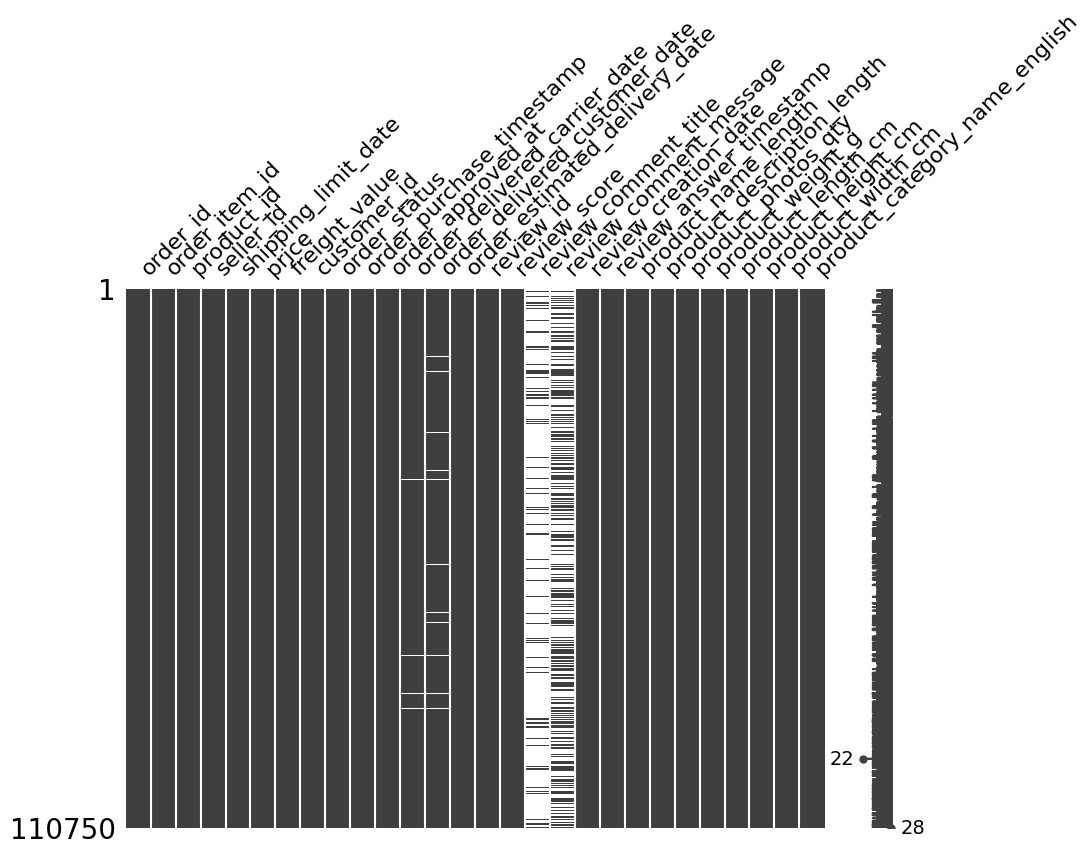

In [9]:
def column_eval(df) -> pd.DataFrame:
    null_count = df.isna().sum()
    total_rows = df.shape[0]
    percent_null = (null_count / total_rows) * 100
    column_dtypes = df.dtypes
    
    null_dataframe = pd.DataFrame(data={"null_count": null_count,
                                        "percent_null": percent_null,
                                        "dytpes": column_dtypes},
                                  index=df.columns)
    return null_dataframe

transactions_eval = column_eval(transactions_df)
display(transactions_eval)
display(msno.matrix(transactions_df, 
                    figsize=(10,7))
        )

##### Dealing with null values

<Axes: >

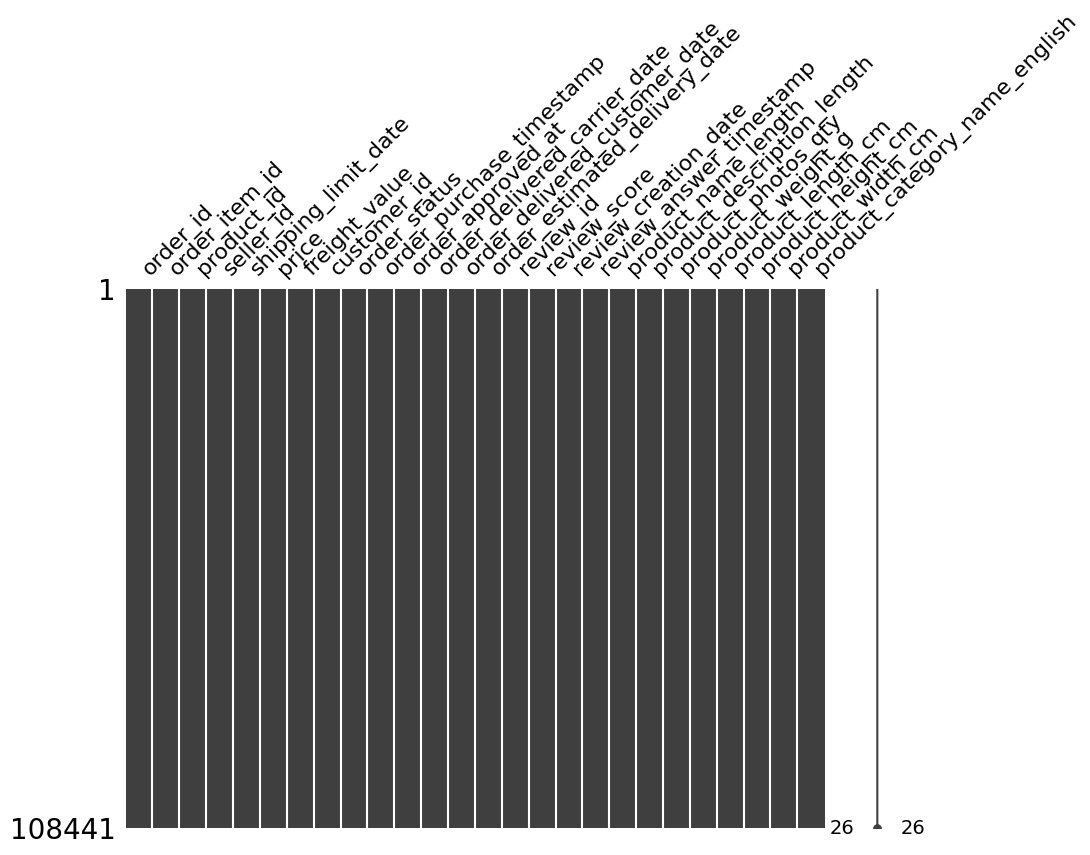

In [10]:
#  remove columns with more than 50% empty values
mostly_null_columns = transactions_eval.query("percent_null > 50").index
transactions_df = transactions_df.drop(columns=mostly_null_columns)

#  remove rows with null values
transactions_df = transactions_df.dropna(axis=0)

display(msno.matrix(transactions_df, 
                    figsize=(10,7) 
                   )
        )

#### Checking for duplicates in the dataset

In [11]:
duplicated = transactions_df.duplicated(subset=["order_id",
                                               "order_item_id",
                                               "product_id",
                                               "customer_id",
                                               "price"
                                               ])

duplicates = transactions_df[duplicated]

sample_duplicate = duplicates.sample().iloc[0,7]

print(f"There are {duplicates.shape[0]} duplicated values")

#  sample duplicated values from this specific customer
print(f"Sample of duplicated transactions from the same customer (customer ID: {sample_duplicate})")
transactions_df.query("customer_id == @sample_duplicate")

There are 635 duplicated values
Sample of duplicated transactions from the same customer (customer ID: 8392c78357bb44adca4a1fcb344a6010)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,...,review_creation_date,review_answer_timestamp,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
68719,2792c4f95b24c1a72641cd404561bdd8,1,e5d446c4355d56bf6c3b7be469a66a42,4e7c18b98d84e05cbae3ff0ff03846c2,2018-03-05 13:35:31,199.0,43.62,8392c78357bb44adca4a1fcb344a6010,delivered,2018-02-27 13:23:38,...,2018-03-15,2018-03-21 17:39:44,48.0,748.0,1.0,11833.0,46.0,53.0,37.0,small_appliances
68720,2792c4f95b24c1a72641cd404561bdd8,1,e5d446c4355d56bf6c3b7be469a66a42,4e7c18b98d84e05cbae3ff0ff03846c2,2018-03-05 13:35:31,199.0,43.62,8392c78357bb44adca4a1fcb344a6010,delivered,2018-02-27 13:23:38,...,2018-03-14,2018-03-21 17:40:54,48.0,748.0,1.0,11833.0,46.0,53.0,37.0,small_appliances


##### Dealing with duplicate values

In [12]:
#  removing duplicated values
transactions_df = transactions_df.drop_duplicates(subset=["order_id",
                                                          "order_item_id",
                                                          "product_id",
                                                          "customer_id",
                                                          "price"
                                                          ])

print(f"There are now {transactions_df.shape[0]} rows, which is {duplicates.shape[0]} less than before")

There are now 107806 rows, which is 635 less than before


#### Checking categorical values

In [13]:
categorical_cols = transactions_df.loc[:, transactions_df.dtypes == "object"]
categorical_cols.nunique()

order_id                         94472
product_id                       31474
seller_id                         2907
customer_id                      94472
order_status                         2
review_id                        94043
product_category_name_english       71
dtype: int64

In [14]:
filtered_categ_cols = categorical_cols.loc[:, categorical_cols.nunique() < 100]

for col in filtered_categ_cols:
    print(f"Unique values in {col}")
    display(transactions_df[col].unique())

Unique values in order_status


array(['delivered', 'canceled'], dtype=object)

Unique values in product_category_name_english


array(['cool_stuff', 'pet_shop', 'furniture_decor', 'perfumery',
       'garden_tools', 'housewares', 'telephony', 'health_beauty',
       'books_technical', 'fashion_bags_accessories', 'bed_bath_table',
       'sports_leisure', 'consoles_games', 'office_furniture',
       'luggage_accessories', 'food', 'agro_industry_and_commerce',
       'electronics', 'computers_accessories',
       'construction_tools_construction', 'audio', 'baby',
       'construction_tools_lights', 'toys', 'stationery',
       'industry_commerce_and_business', 'watches_gifts', 'auto',
       'home_appliances', 'kitchen_dining_laundry_garden_furniture',
       'air_conditioning', 'home_confort', 'fixed_telephony',
       'small_appliances_home_oven_and_coffee', 'diapers_and_hygiene',
       'signaling_and_security', 'musical_instruments',
       'small_appliances', 'costruction_tools_garden', 'art',
       'home_construction', 'books_general_interest', 'party_supplies',
       'construction_tools_safety', 'cine_p

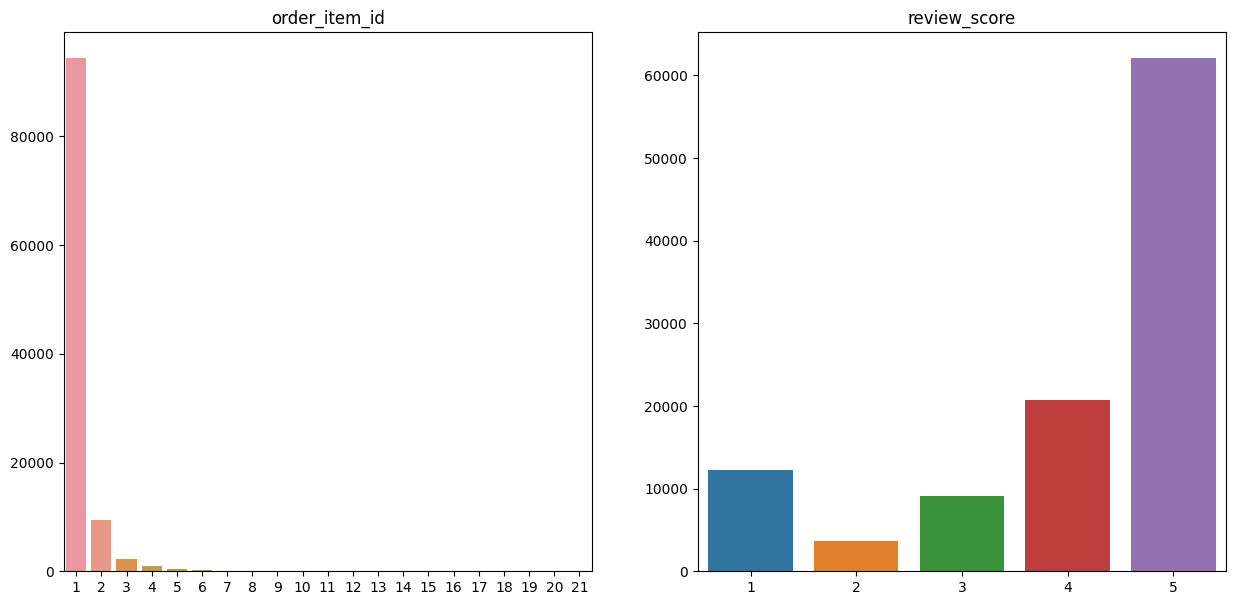

In [15]:
int_cols = transactions_df.loc[:, transactions_df.dtypes == "int64"]

fig = plt.figure(figsize=(15,7))
fig.subplots_adjust(hspace=0.3)

for i, col in enumerate(int_cols):
    plt.subplot(1,2,i+1, label=col)
    int_frequency = transactions_df[col].value_counts()
    sns.barplot(x=int_frequency.index, y=int_frequency.values)
    plt.title(col)

#### Checking numerical columns (outlier detection)

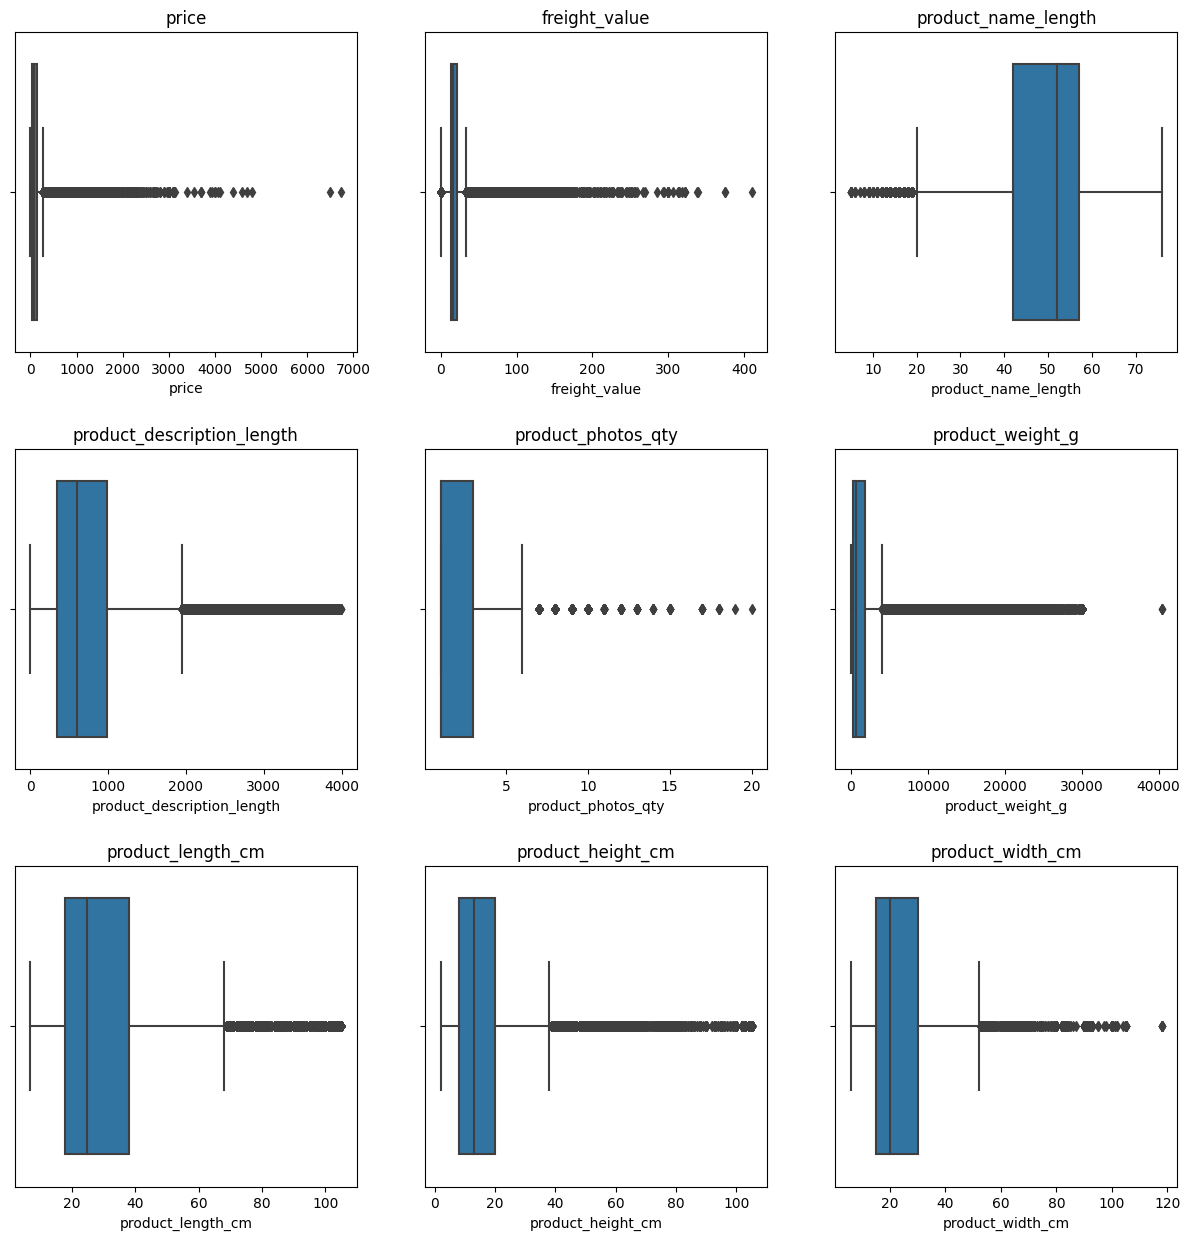

In [16]:
float_cols = transactions_df.loc[:, transactions_df.dtypes == "float64"]

fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.3)

for i, col in enumerate(float_cols):
    plt.subplot(3,3,i+1, label=col)
    sns.boxplot(data=transactions_df, x=col)
    plt.title(col)

#### Checking datetime columns

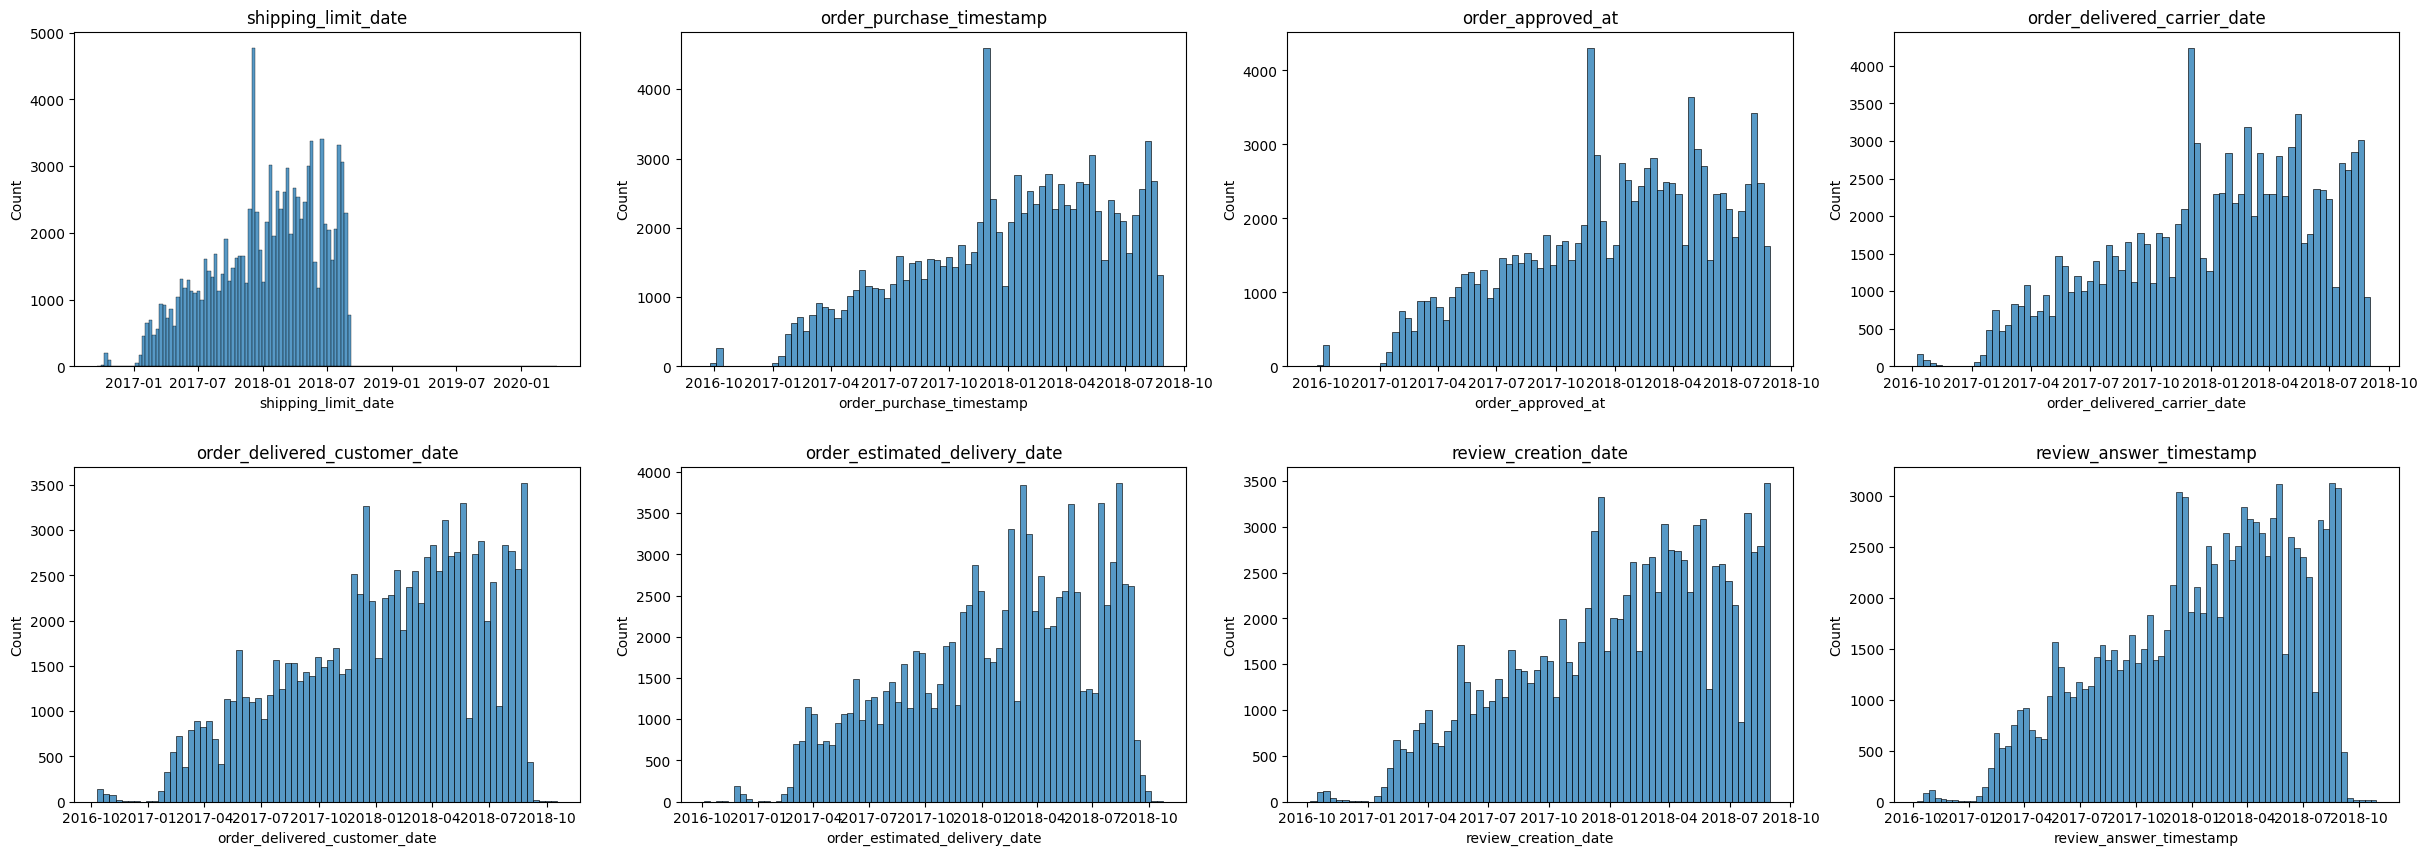

In [17]:
datetime_cols = transactions_df.loc[:, transactions_df.dtypes == "datetime64[ns]"]

fig = plt.figure(figsize=(30,10))
fig.subplots_adjust(hspace=0.3)

for i, col in enumerate(datetime_cols):
    plt.subplot(2,4,i+1, label=col)
    sns.histplot(data=transactions_df, x=col)
    plt.title(col)

### **Feature engineering**

#### Feature selection

In [18]:
relevant_features = ['product_id',
                     'price',
                     'order_purchase_timestamp',
                     'review_score',
                     'product_weight_g',
                     'product_length_cm',
                     'product_height_cm',
                     'product_width_cm',
                     'product_category_name_english',
                     ]

Why are the others deemed irrelevant? yung mga ibang dates can be useful when optimizing price for freight but that's not what we're doing naman

In [19]:
main_df = transactions_df.copy()
main_df = main_df[relevant_features]
main_df.sample(5)

,product_id,price,order_purchase_timestamp,review_score,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
106664,56e8054262b705086dd99fc97b01a9e4,10.00,2018-04-05 11:22:54,5,100.0,19.0,2.0,19.0,books_general_interest
103309,235bec397501f88e0593219e90c28b4d,55.00,2017-11-28 11:25:56,1,800.0,32.0,19.0,30.0,toys
61836,770c257cdfc072fb50ebf2bbd6696fe1,69.90,2018-02-28 10:21:31,4,1150.0,18.0,18.0,11.0,baby
57662,210feb9ae3b060d29ec884aac60e5f10,149.99,2017-11-02 17:36:04,5,1050.0,37.0,22.0,26.0,cool_stuff
22364,88dd63919fc9ab693803578a04a20209,34.99,2017-07-28 19:53:43,5,217.0,16.0,14.0,14.0,computers_accessories


#### Feature generation

In [20]:
main_df["day_of_week"] = main_df["order_purchase_timestamp"].dt.day_of_week
main_df["is_weekday"] = main_df["day_of_week"] < 5
main_df["month"] = main_df["order_purchase_timestamp"].dt.month
main_df["year"] = main_df["order_purchase_timestamp"].dt.year
main_df["hour"] = main_df["order_purchase_timestamp"].dt.hour
main_df["date_purchased"] = pd.to_datetime(main_df["order_purchase_timestamp"].dt.date)
main_df.sample(5)

,product_id,price,order_purchase_timestamp,review_score,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,day_of_week,is_weekday,month,year,hour,date_purchased
31530,0152f69b6cf919bcdaf117aa8c43e5a2,13.90,2017-04-20 11:33:57,5,250.0,40.0,4.0,30.0,bed_bath_table,3,True,4,2017,11,2017-04-20
97113,b415213dee0b8051901b7ebe5a6b99f4,147.79,2018-08-13 11:02:58,5,415.0,23.0,19.0,18.0,fashion_bags_accessories,0,True,8,2018,11,2018-08-13
55075,1fce7b244f4a45431713165a869f5f32,154.17,2017-11-15 17:23:31,5,575.0,16.0,22.0,16.0,perfumery,2,True,11,2017,17,2017-11-15
10991,d33a74e1b6cfc152b6b3f43324d54987,14.99,2018-07-21 17:25:03,3,350.0,27.0,4.0,34.0,computers_accessories,5,False,7,2018,17,2018-07-21
79191,a129c8279ee7fa447a6e8726f619dac7,329.00,2018-05-31 18:28:14,5,28750.0,40.0,62.0,22.0,baby,3,True,5,2018,18,2018-05-31


In [21]:
main_df["product_volume_cm3"] = main_df["product_length_cm"] * main_df["product_width_cm"] * main_df["product_height_cm"]
main_df.sample(5)

,product_id,price,order_purchase_timestamp,review_score,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,day_of_week,is_weekday,month,year,hour,date_purchased,product_volume_cm3
55023,f177b434709ecb652dbee4f4b19aef2f,29.99,2018-02-17 01:27:48,4,200.0,16.0,16.0,16.0,fashion_bags_accessories,5,False,2,2018,1,2018-02-17,4096.0
96277,3386491e65bf02586461d30dc3fe53f1,27.99,2017-11-24 01:58:41,3,350.0,17.0,4.0,12.0,telephony,4,True,11,2017,1,2017-11-24,816.0
54531,f7bb503725fb4d7bb55301d5bceba728,99.70,2017-05-02 21:33:57,1,400.0,22.0,18.0,12.0,sports_leisure,1,True,5,2017,21,2017-05-02,4752.0
89584,b9a4c42463488180d477e980b5bca0d7,109.90,2017-06-24 20:54:22,5,1850.0,48.0,8.0,39.0,bed_bath_table,5,False,6,2017,20,2017-06-24,14976.0
72454,127d3b28487be63864af02f25333decd,12.97,2017-08-19 16:06:01,5,150.0,18.0,6.0,11.0,telephony,5,False,8,2017,16,2017-08-19,1188.0


#### Final diagnosis of main_df

In [22]:
main_df.sample(5)

,product_id,price,order_purchase_timestamp,review_score,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,day_of_week,is_weekday,month,year,hour,date_purchased,product_volume_cm3
76966,73c92dd0decac87c55334f6ae653ad36,179.49,2018-02-02 15:26:38,5,550.0,16.0,21.0,18.0,auto,4,True,2,2018,15,2018-02-02,6048.0
102909,f71a8f28bdda01d104586e674b4303de,16.80,2017-02-15 20:49:15,4,550.0,17.0,27.0,17.0,housewares,2,True,2,2017,20,2017-02-15,7803.0
109239,40c6502218c2b8ae624cd1576aac13c1,59.00,2017-07-02 12:03:31,5,550.0,17.0,15.0,15.0,housewares,6,False,7,2017,12,2017-07-02,3825.0
17541,8569e9a17c2b63e9e6e998dac2dfa533,40.75,2018-08-18 21:10:16,5,150.0,16.0,10.0,16.0,health_beauty,5,False,8,2018,21,2018-08-18,2560.0
107972,cf55509ea8edaaac1d28fdb16e48fc22,207.25,2018-06-15 14:08:12,5,250.0,17.0,7.0,17.0,musical_instruments,4,True,6,2018,14,2018-06-15,2023.0


In [23]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107806 entries, 0 to 110749
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   product_id                     107806 non-null  object        
 1   price                          107806 non-null  float64       
 2   order_purchase_timestamp       107806 non-null  datetime64[ns]
 3   review_score                   107806 non-null  int64         
 4   product_weight_g               107806 non-null  float64       
 5   product_length_cm              107806 non-null  float64       
 6   product_height_cm              107806 non-null  float64       
 7   product_width_cm               107806 non-null  float64       
 8   product_category_name_english  107806 non-null  object        
 9   day_of_week                    107806 non-null  int64         
 10  is_weekday                     107806 non-null  bool          
 11  

In [24]:
main_row, main_col = main_df.shape

print(f"main_df has a total of {main_row} entries and {main_col} features.")

main_df has a total of 107806 entries and 16 features.


### **Exploratory Data Analysis (EDA)**

#### Sampling for our dataset

In [25]:
sampled_df = main_df.copy()
sampled_df = sampled_df.sample(frac=.2, random_state=25)
sampled_df

,product_id,price,order_purchase_timestamp,review_score,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,day_of_week,is_weekday,month,year,hour,date_purchased,product_volume_cm3
69574,113f80f12c8892f0c59206f70b862b40,19.90,2018-07-14 09:47:09,5,250.0,16.0,10.0,16.0,bed_bath_table,5,False,7,2018,9,2018-07-14,2560.0
109365,367f4a5ae70f2e8de8d9eb1c13f280b1,9.00,2017-05-26 15:53:43,5,1950.0,20.0,6.0,20.0,sports_leisure,4,True,5,2017,15,2017-05-26,2400.0
10626,19c91ef95d509ea33eda93495c4d3481,122.99,2018-08-07 20:27:57,4,700.0,25.0,12.0,19.0,health_beauty,1,True,8,2018,20,2018-08-07,5700.0
79627,6cbe4bd19efc4606eb2a9448a47e232e,38.90,2018-02-15 10:03:54,4,300.0,30.0,20.0,20.0,consoles_games,3,True,2,2018,10,2018-02-15,12000.0
44343,704ef63ad0ac345842ea734060a83db2,74.90,2018-01-12 18:43:34,4,850.0,38.0,10.0,38.0,bed_bath_table,4,True,1,2018,18,2018-01-12,14440.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17383,f5badee8a0e679f057ec0ca4f0f32dcb,109.90,2017-11-25 09:20:17,5,450.0,20.0,10.0,15.0,construction_tools_construction,5,False,11,2017,9,2017-11-25,3000.0
43099,85337022853da10b8f5fd7d1ef180421,39.90,2017-08-27 14:11:40,2,200.0,25.0,5.0,15.0,consoles_games,6,False,8,2017,14,2017-08-27,1875.0
31246,ce4951e4e9e73626368438f1dbc05dd2,33.00,2018-02-26 14:31:31,5,400.0,16.0,23.0,11.0,books_technical,0,True,2,2018,14,2018-02-26,4048.0
42027,65266b2da20d04dbe00c5c2d3bb7859e,23.90,2018-05-14 14:36:06,5,250.0,51.0,15.0,15.0,stationery,0,True,5,2018,14,2018-05-14,11475.0


### Checking out distribution of features

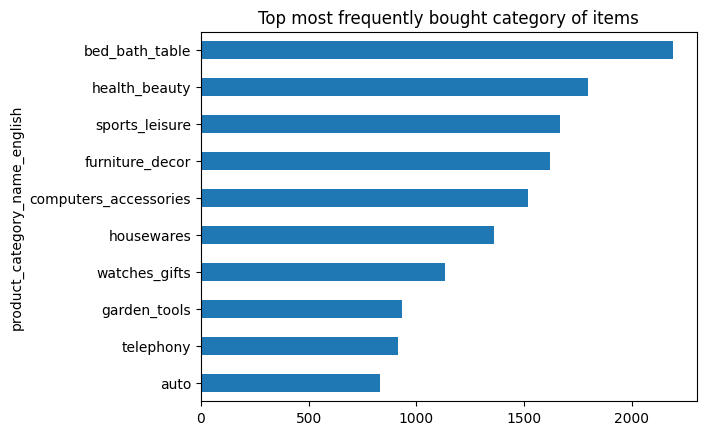

In [26]:
(sampled_df
 .groupby("product_category_name_english")["product_id"]
 .count()
 .sort_values(ascending=False)
 .head(10)
 .plot
 .barh(title="Top most frequently bought category of items")
 .invert_yaxis()
 )

<Axes: title={'center': 'Distribution of review scores'}>

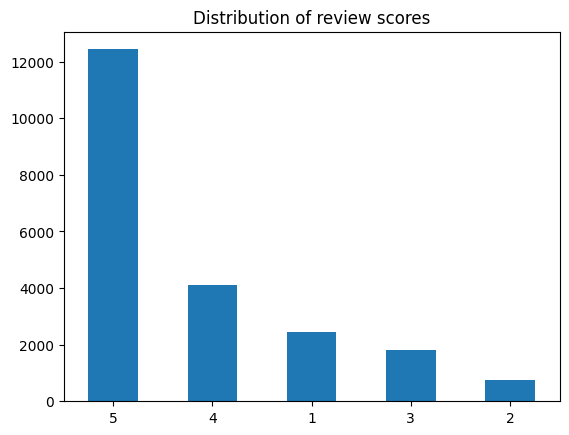

In [27]:
(sampled_df
 .review_score
 .value_counts()
 .plot
 .bar(rot=0,
      title="Distribution of review scores"))

<Axes: title={'center': 'Distribution of purchases made in each year'}>

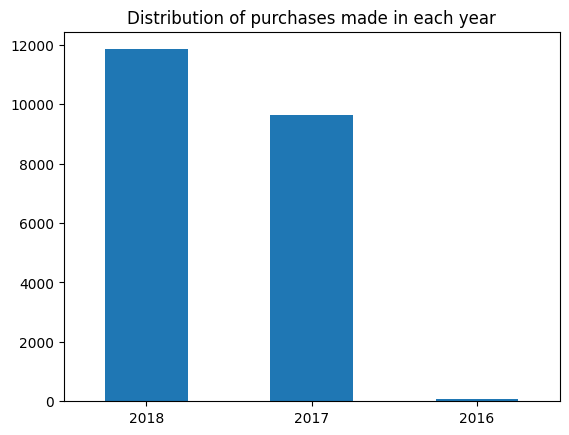

In [28]:
(sampled_df
 .year
 .value_counts()
 .plot
 .bar(rot=0,
       title="Distribution of purchases made in each year"))

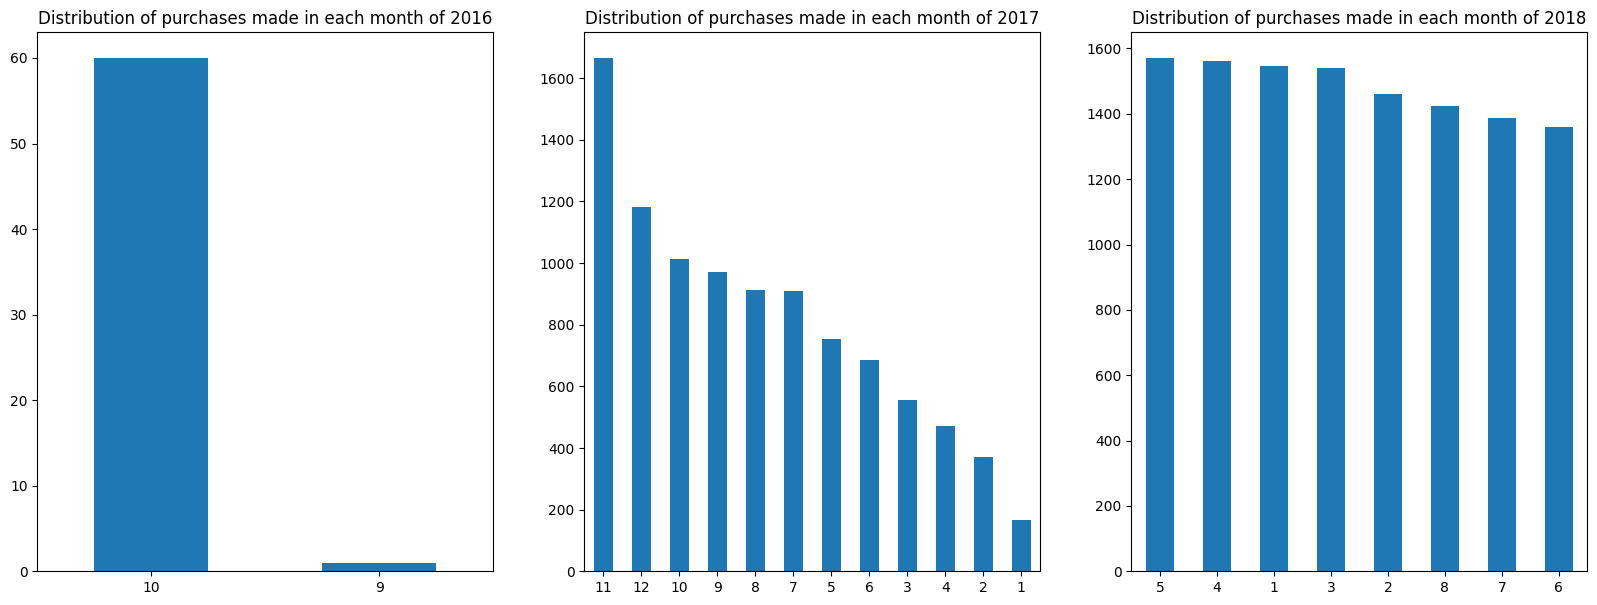

In [29]:
fig, ax = plt.subplots(1,3, figsize=(20,7))

years = sampled_df.year.sort_values().unique()

for i, year in enumerate(years):
    (sampled_df
    .query("year == @year")
    .month
    .value_counts()
    .plot
    .bar(rot=0,
        title=f"Distribution of purchases made in each month of {year}",
        ax=ax[i])
    )

Text(0.5, 0, '[0] Monday - [6] Sunday')

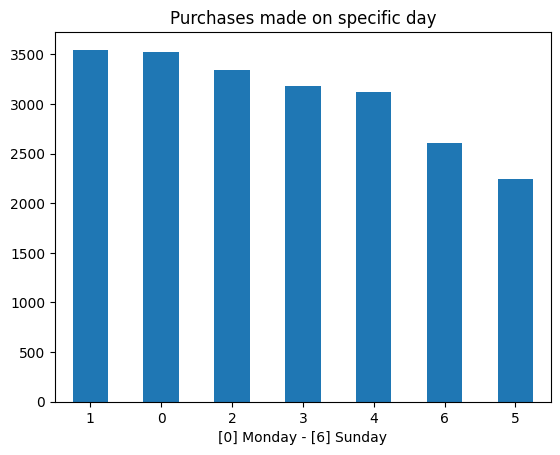

In [30]:
(sampled_df
 .day_of_week.
 value_counts()
 .plot
 .bar(rot=0,
      title="Purchases made on specific day"
      )
 )
plt.xlabel("[0] Monday - [6] Sunday")

<Axes: title={'center': 'Purchase made on a weekday?'}>

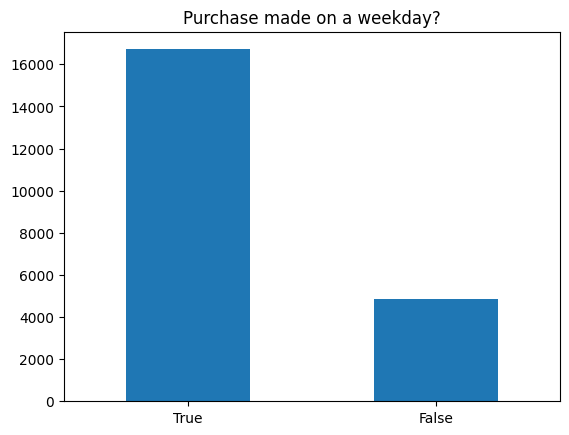

In [31]:
(sampled_df
 .is_weekday
 .value_counts()
 .plot
 .bar(rot=0,
      title="Purchase made on a weekday?")
 )

<Axes: title={'center': 'Distribution of Purchases by hour in a day'}, ylabel='Frequency'>

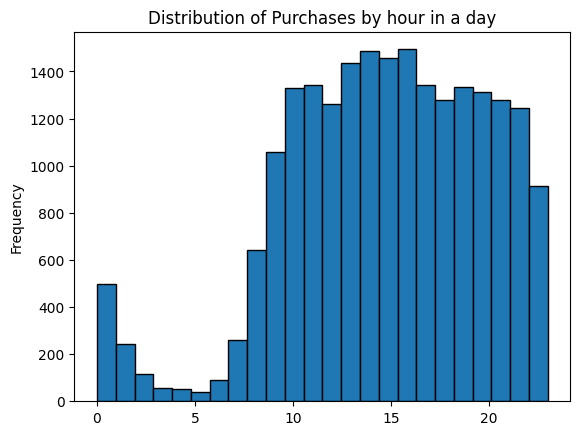

In [32]:
(sampled_df
 .hour
 .plot
 .hist(bins=24,edgecolor="black", title="Distribution of Purchases by hour in a day"))

Text(0.5, 1.0, 'Frequency of transactions per day from 2016-2018')

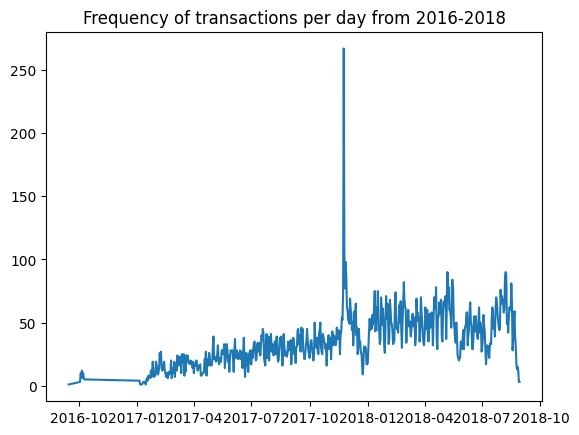

In [33]:
purchase_freq_date = sampled_df.date_purchased.value_counts().sort_index()
plt.plot(purchase_freq_date.index, purchase_freq_date.values)
plt.title("Frequency of transactions per day from 2016-2018")

<Axes: title={'center': 'Frequency of transactions per month from 2016-2018'}, xlabel='date_purchased'>

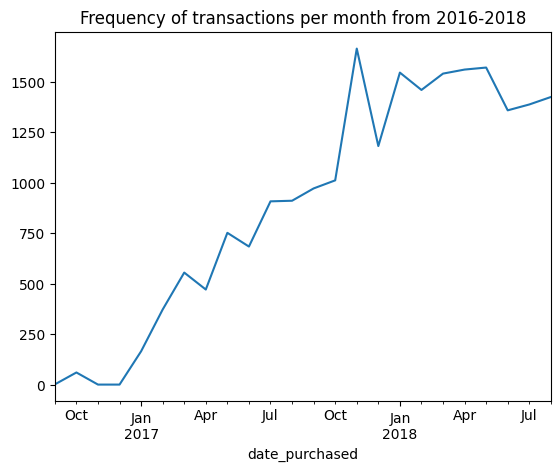

In [34]:
sampled_df.groupby(pd.Grouper(key="date_purchased", freq="M"))["product_id"].count().plot.line(title="Frequency of transactions per month from 2016-2018")

## Prepping the Data for Modelling

#### Creating dummy variables

In [35]:
#  adopting the sampled dataset
main_df = sampled_df

label_encoder = LabelEncoder()

main_df["product_category_name_english"] = label_encoder.fit_transform(main_df["product_category_name_english"])
main_df['is_weekday'] = label_encoder.fit_transform(main_df["is_weekday"])

main_df

,product_id,price,order_purchase_timestamp,review_score,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,day_of_week,is_weekday,month,year,hour,date_purchased,product_volume_cm3
69574,113f80f12c8892f0c59206f70b862b40,19.90,2018-07-14 09:47:09,5,250.0,16.0,10.0,16.0,7,5,0,7,2018,9,2018-07-14,2560.0
109365,367f4a5ae70f2e8de8d9eb1c13f280b1,9.00,2017-05-26 15:53:43,5,1950.0,20.0,6.0,20.0,64,4,1,5,2017,15,2017-05-26,2400.0
10626,19c91ef95d509ea33eda93495c4d3481,122.99,2018-08-07 20:27:57,4,700.0,25.0,12.0,19.0,43,1,1,8,2018,20,2018-08-07,5700.0
79627,6cbe4bd19efc4606eb2a9448a47e232e,38.90,2018-02-15 10:03:54,4,300.0,30.0,20.0,20.0,16,3,1,2,2018,10,2018-02-15,12000.0
44343,704ef63ad0ac345842ea734060a83db2,74.90,2018-01-12 18:43:34,4,850.0,38.0,10.0,38.0,7,4,1,1,2018,18,2018-01-12,14440.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17383,f5badee8a0e679f057ec0ca4f0f32dcb,109.90,2017-11-25 09:20:17,5,450.0,20.0,10.0,15.0,17,5,0,11,2017,9,2017-11-25,3000.0
43099,85337022853da10b8f5fd7d1ef180421,39.90,2017-08-27 14:11:40,2,200.0,25.0,5.0,15.0,16,6,0,8,2017,14,2017-08-27,1875.0
31246,ce4951e4e9e73626368438f1dbc05dd2,33.00,2018-02-26 14:31:31,5,400.0,16.0,23.0,11.0,10,0,1,2,2018,14,2018-02-26,4048.0
42027,65266b2da20d04dbe00c5c2d3bb7859e,23.90,2018-05-14 14:36:06,5,250.0,51.0,15.0,15.0,65,0,1,5,2018,14,2018-05-14,11475.0


#### Converting non-integers, non-string, and non-datetime columns to integer

In [36]:
non_int_cols = main_df.loc[:, (main_df.dtypes != "int64") & (main_df.dtypes != "datetime64[ns]") & (main_df.dtypes != "object")].columns

for cols in non_int_cols:
    main_df[cols] = main_df[cols].astype("int64")
    
main_df.dtypes

product_id                               object
price                                     int64
order_purchase_timestamp         datetime64[ns]
review_score                              int64
product_weight_g                          int64
product_length_cm                         int64
product_height_cm                         int64
product_width_cm                          int64
product_category_name_english             int64
day_of_week                               int64
is_weekday                                int64
month                                     int64
year                                      int64
hour                                      int64
date_purchased                   datetime64[ns]
product_volume_cm3                        int64
dtype: object

#### Selecting features

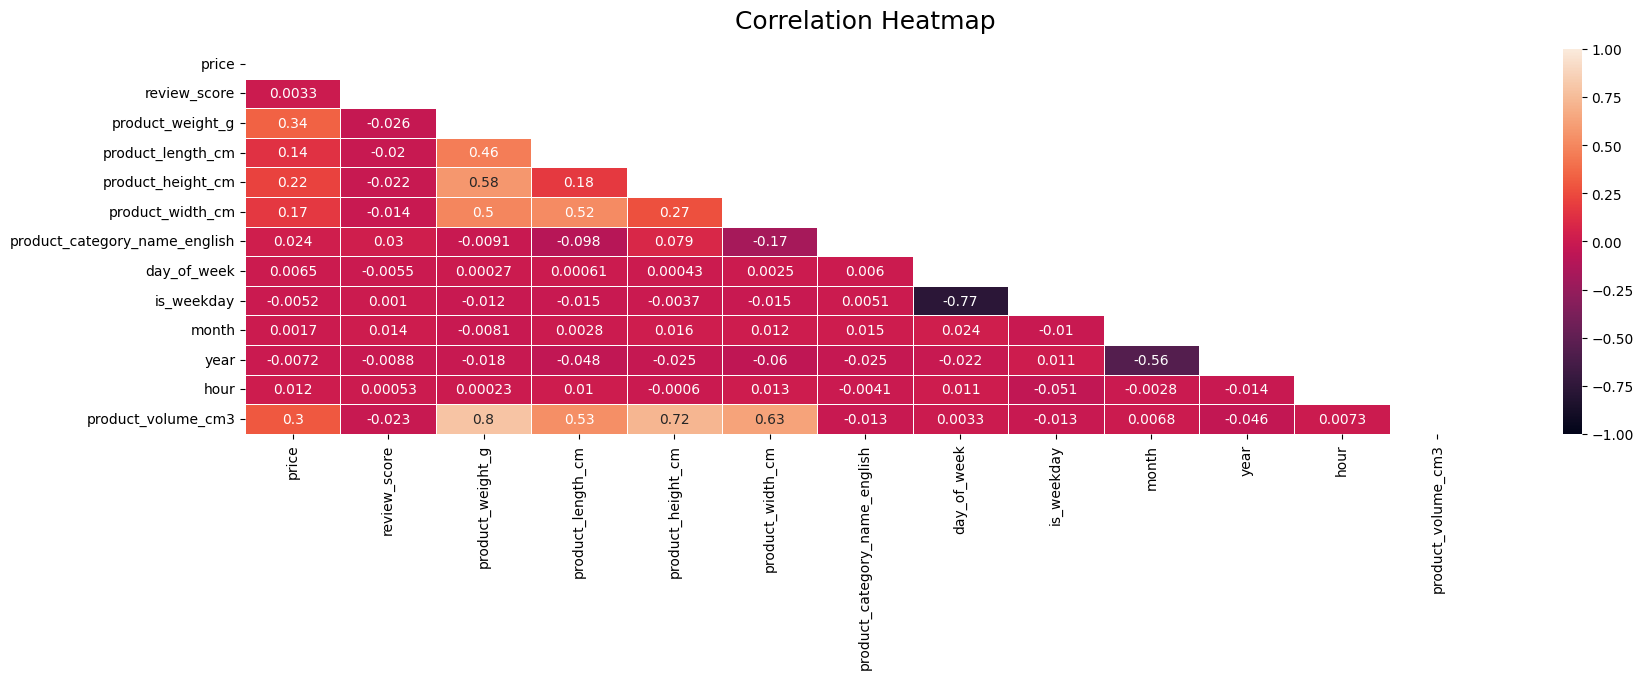

In [37]:
mask = np.triu(np.ones_like(main_df.corr(numeric_only=True)))
corr = main_df.corr(numeric_only=True)

plt.figure(figsize=(20, 5))
sns.heatmap(corr,
            mask=mask, 
            annot=True, 
            vmin=-1,
            vmax=1,
            linewidths=.5)
plt.title('Correlation Heatmap', fontdict={'fontsize': 18}, pad=15);

#### Filtering main dataset with positively correlated features

In [38]:
correlated_features = ["price",
                       "product_weight_g",
                       "product_length_cm",
                       "product_height_cm",
                       "product_width_cm",
                       "product_volume_cm3",
                       "review_score"
                       ]

main_df = main_df[correlated_features]

#### Scaling dataset

In [39]:
# scaler = MinMaxScaler()

# main_df = pd.DataFrame(scaler.fit_transform(main_df), columns=main_df.columns)

#### Splitting main dataset

In [40]:
#  split dataset in features and target variables
X, y = main_df.iloc[:, 1:], main_df.iloc[:, 0]

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

## Regression Trees for Price Optimization

### Building Regression Tree Model

In [42]:
# # Create Decision Tree classifer object
# clf = DecisionTreeClassifier()

# # Train Decision Tree Classifer
# clf = clf.fit(X_train,y_train)

# #Predict the response for test dataset
# y_pred = clf.predict(X_test)

In [43]:
# Create Decision Tree Regressor
reg_tree = DecisionTreeRegressor(random_state=40)

# Train Decision Tree Regressor
reg_tree = reg_tree.fit(X_train,y_train)

#  Evaluating the reg_tree 
train_pred = reg_tree.predict(X_train)
train_score = reg_tree.score(X_train, y_train)
train_mse = mean_squared_error(y_train, train_pred)
print("Training Set Scores")
print(f"MSE: {train_mse}")
print(f"RMSE: {train_mse**(1/2)}")
print(f"R-square: {train_score}")

Training Set Scores
MSE: 387.17990918955803
RMSE: 19.676887690627247
R-square: 0.9887921442790625


#### Evaluating the Initial Model

In [44]:
#  Evaluating the reg_tree 
test_pred = reg_tree.predict(X_test)
test_score = reg_tree.score(X_test, y_test)
test_mse = mean_squared_error(y_test, test_pred)
print("Testing Set Scores")
print(f"MSE: {test_mse}")
print(f"RMSE: {test_mse**(1/2)}")
print(f"R-square: {test_score}")

base_results_dict = {"score": test_score,
                     "MSE": test_mse,
                     "RMSE": test_mse**(1/2)}

Testing Set Scores
MSE: 44397.4771126771
RMSE: 210.70708842532352
R-square: 0.01022465141798179


In [45]:
# # Model Accuracy, how often is the classifier correct
# print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

#### Hyperparameter tuning

In [46]:
param_grid = {"criterion": ["squared_error", "absolute_error", "poisson"],
              "splitter":  ["best", "random"],
              "max_features": ["sqrt", "log2"],
              "min_samples_leaf": range(2,11),
              "max_depth": range(5,21)
              }

##### Using RandomizedSearchCV

In [47]:
reg_tree_rs = DecisionTreeRegressor(random_state=40)
random_search = RandomizedSearchCV(estimator=reg_tree_rs, 
                                   param_distributions=param_grid,
                                   verbose=3,
                                   return_train_score=True)
random_search = random_search.fit(X_train, y_train)

best_params_rs = random_search.best_params_
best_regtree_rs = DecisionTreeRegressor(criterion=best_params_rs["criterion"],
                                        max_features=best_params_rs["max_features"],
                                        min_samples_leaf=best_params_rs["min_samples_leaf"],
                                        splitter=best_params_rs["splitter"],
                                        random_state=40)

best_regtree_rs = best_regtree_rs.fit(X_train, y_train)

training_score = best_regtree_rs.score(X_train, y_train)

print(best_params_rs)

#  Evaluating the train set with best_regtree_rs 
train_pred = best_regtree_rs.predict(X_train)
train_score = best_regtree_rs.score(X_train, y_train)
train_mse = mean_squared_error(y_train, train_pred)
print("Training Set Scores")
print(f"MSE: {train_mse}")
print(f"RMSE: {train_mse**(1/2)}")
print(f"R-square: {train_score}\n")

#  Evaluating the test set with best_regtree_rs 
test_pred = best_regtree_rs.predict(X_test)
test_score = best_regtree_rs.score(X_test, y_test)
test_mse = mean_squared_error(y_test, test_pred)
print("Testing Set Scores")
print(f"MSE: {test_mse}")
print(f"RMSE: {test_mse**(1/2)}")
print(f"R-square: {test_score}")

rs_results_dict = {"score": test_score,
                   "MSE": test_mse,
                   "RMSE": test_mse**(1/2)}

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END criterion=poisson, max_depth=11, max_features=log2, min_samples_leaf=6, splitter=random;, score=(train=0.188, test=0.116) total time=   0.0s
[CV 2/5] END criterion=poisson, max_depth=11, max_features=log2, min_samples_leaf=6, splitter=random;, score=(train=0.167, test=0.147) total time=   0.0s
[CV 3/5] END criterion=poisson, max_depth=11, max_features=log2, min_samples_leaf=6, splitter=random;, score=(train=0.184, test=0.164) total time=   0.0s
[CV 4/5] END criterion=poisson, max_depth=11, max_features=log2, min_samples_leaf=6, splitter=random;, score=(train=0.170, test=0.107) total time=   0.0s
[CV 5/5] END criterion=poisson, max_depth=11, max_features=log2, min_samples_leaf=6, splitter=random;, score=(train=0.167, test=0.087) total time=   0.0s
[CV 1/5] END criterion=squared_error, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=random;, score=(train=0.176, test=0.090) total time=   0.0s
[CV 2/5] E

##### Using GridSearchCV

In [48]:
reg_tree_gs = DecisionTreeRegressor(random_state=40)
grid_search = GridSearchCV(estimator=reg_tree_gs, 
                           param_grid=param_grid,
                           verbose=3,
                           return_train_score=True)
grid_search = grid_search.fit(X_train, y_train)

best_params_gs = grid_search.best_params_
best_regtree_gs = DecisionTreeRegressor(criterion=best_params_gs["criterion"],
                                        max_features=best_params_gs["max_features"],
                                        min_samples_leaf=best_params_gs["min_samples_leaf"],
                                        splitter=best_params_gs["splitter"],
                                        random_state=40)

best_regtree_gs = best_regtree_gs.fit(X_train, y_train)

training_score = best_regtree_gs.score(X_train, y_train)

print(best_params_gs)

#  Evaluating the train set with best_regtree_gs 
train_pred = best_regtree_gs.predict(X_train)
train_score = best_regtree_gs.score(X_train, y_train)
train_mse = mean_squared_error(y_train, train_pred)
print("Training Set Scores")
print(f"MSE: {train_mse}")
print(f"RMSE: {train_mse**(1/2)}")
print(f"R-square: {train_score}\n")

#  Evaluating the test set with best_regtree_gs 
test_pred = best_regtree_gs.predict(X_test)
test_score = best_regtree_gs.score(X_test, y_test)
test_mse = mean_squared_error(y_test, test_pred)
print("Testing Set Scores")
print(f"MSE: {test_mse}")
print(f"RMSE: {test_mse**(1/2)}")
print(f"R-square: {test_score}")

gs_results_dict = {"score": test_score,
                   "MSE": test_mse,
                   "RMSE": test_mse**(1/2)}

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
[CV 1/5] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best;, score=(train=0.246, test=0.118) total time=   0.0s
[CV 2/5] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best;, score=(train=0.238, test=0.132) total time=   0.0s
[CV 3/5] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best;, score=(train=0.255, test=0.139) total time=   0.0s
[CV 4/5] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best;, score=(train=0.234, test=0.033) total time=   0.0s
[CV 5/5] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best;, score=(train=0.201, test=-0.015) total time=   0.0s
[CV 1/5] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=random;, score=(train=0.130, test=0.088) total tim

##### Selecting best parameters to use from the 3 different parameters suggested (using test scores as metric)

In [49]:
base_results_dict

{'score': 0.01022465141798179,
 'MSE': 44397.4771126771,
 'RMSE': 210.70708842532352}

In [50]:
rs_results_dict

{'score': 0.18052645061353745,
 'MSE': 36758.39997980601,
 'RMSE': 191.72480272465012}

In [51]:
gs_results_dict

{'score': 0.1628385889391033,
 'MSE': 37551.808741691144,
 'RMSE': 193.78289073520176}

### **Modelling Best Regression Tree**

In [64]:
best_regtree = DecisionTreeRegressor(criterion=best_params_rs["criterion"],
                                     max_features=best_params_rs["max_features"],
                                     min_samples_leaf=best_params_rs["min_samples_leaf"],
                                     splitter=best_params_rs["splitter"],
                                     random_state=40
                                     )

best_regtree = best_regtree.fit(X_train, y_train)

training_score = best_regtree.score(X_train, y_train)

#  Evaluating the train set with best_regtree 
train_pred = best_regtree.predict(X_train)
train_score = best_regtree.score(X_train, y_train)
train_mse = mean_squared_error(y_train, train_pred)
print("Training Set Scores")
print(f"MSE: {train_mse}")
print(f"RMSE: {train_mse**(1/2)}")
print(f"R-square: {train_score}\n")

#  Evaluating the test set with best_regtree 
test_pred = best_regtree.predict(X_test)
test_score = best_regtree.score(X_test, y_test)
test_mse = mean_squared_error(y_test, test_pred)
test_mae = mean_absolute_error(y_test, test_pred)
print("Testing Set Scores")
print(f"MSE: {test_mse}")
print(f"MAE: {test_mae}")
print(f"RMSE: {test_mse**(1/2)}")
print(f"R-square: {test_score}")

rs_results_dict = {"score": test_score,
                   "MSE": test_mse,
                   "RMSE": test_mse**(1/2)}

Training Set Scores
MSE: 19723.580339784712
RMSE: 140.44066483673706
R-square: 0.42905342580572814

Testing Set Scores
MSE: 36758.39997980601
MAE: 69.25444219714312
RMSE: 191.72480272465012
R-square: 0.18052645061353745


### Visualizing the Regression Tree

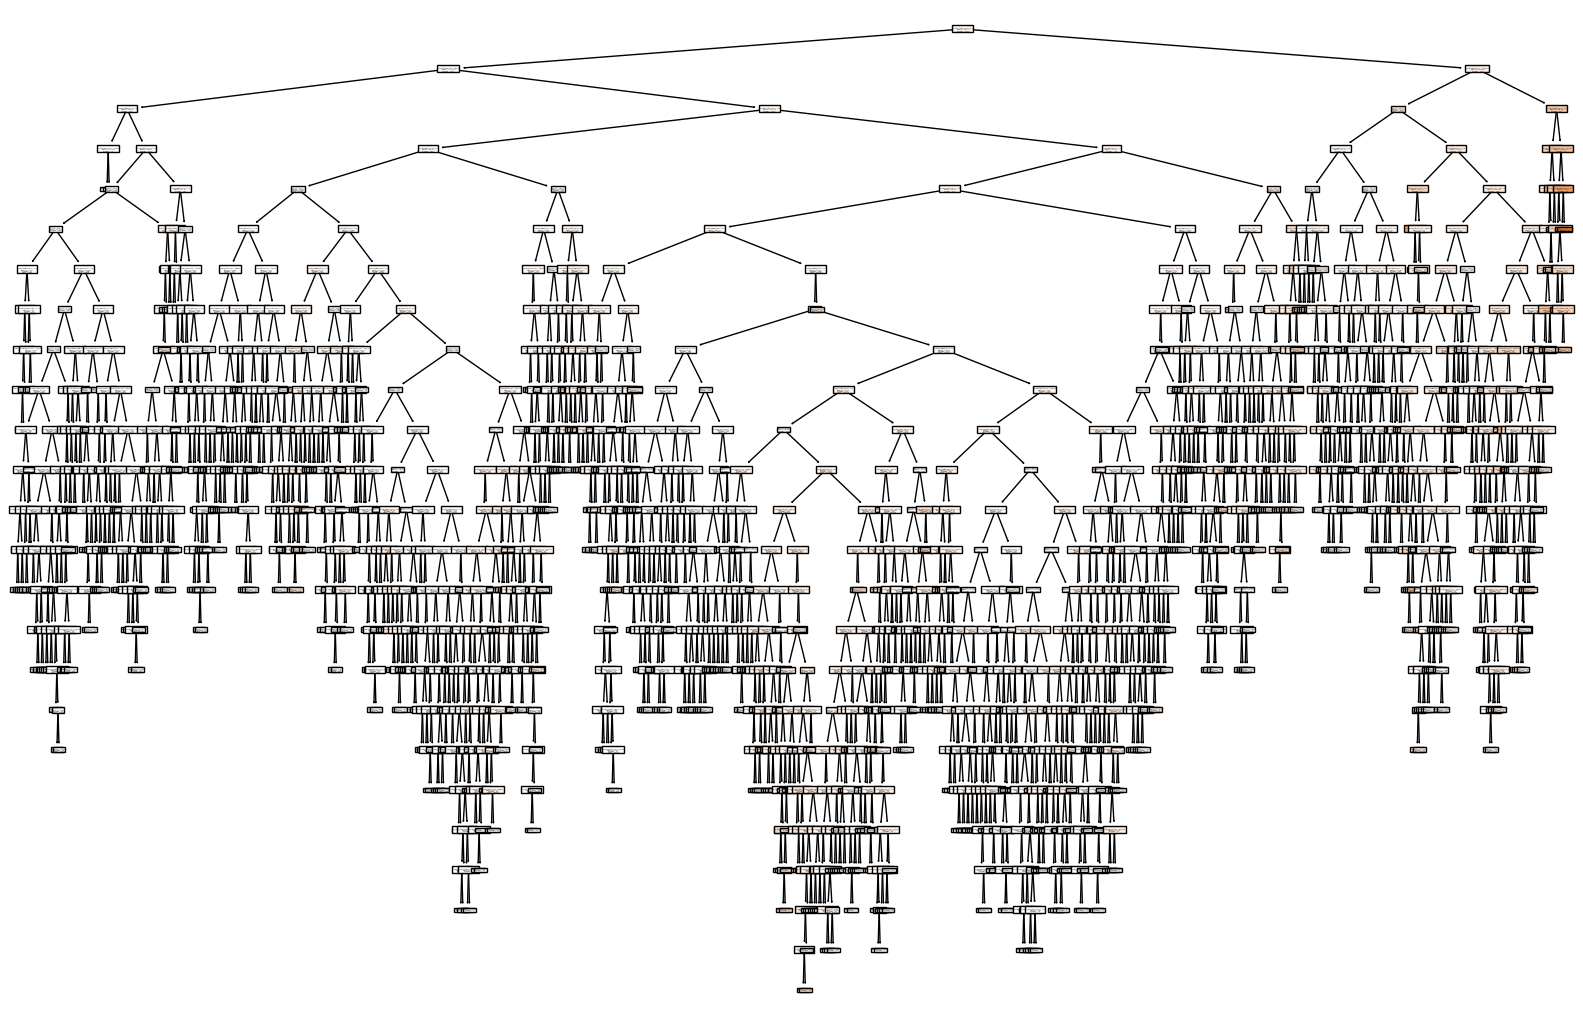

In [66]:
fig = plt.figure(figsize=(20,13))
_ = tree.plot_tree(best_regtree, 
                   feature_names=main_df.columns,
                   filled=True
                   )

To evaluate, the R-square value of 0.4929 indicates that the model is able to show about 43% of the variability in the data. Which shows how the testing set scores indicate how well the model is able to perform on the new and unseen data. MSE and RMSE were used as a measurement for the average square and root mean squared errors respectively. Wherein, the R-square value of 0.181 suggests that the model explain about 18% of the variability in the testing data, which shows that it is lower than the R-squared for the training data. Ultimately, the results indicates that there are some degree of overfitting.

### **Feature Importance and SHAP Values**

In [67]:
perm1 = PermutationImportance(best_regtree, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm1, feature_names = X_test.columns.tolist())

Weight,Feature
0.3128 ± 0.0268,product_weight_g
0.2724 ± 0.0245,product_height_cm
0.2649 ± 0.0142,product_length_cm
0.2224 ± 0.0212,product_volume_cm3
0.1468 ± 0.0182,product_width_cm
-0.0026 ± 0.0020,review_score


In [68]:
explainer = shap.TreeExplainer(best_regtree, datamodel_output="raw", feature_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(X_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


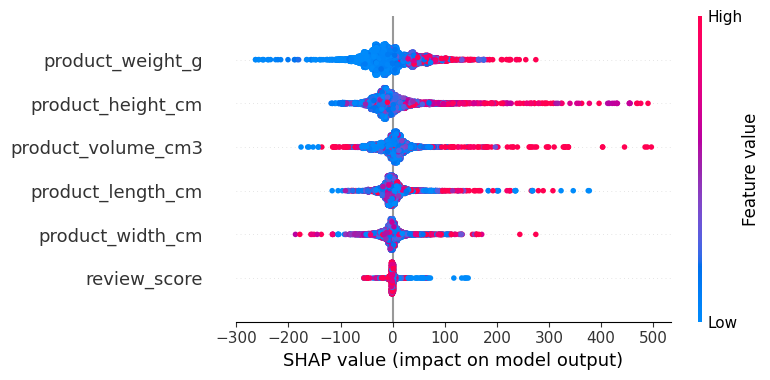

In [69]:
shap.summary_plot(shap_values, X_test)

The visualization presented in this section reports the values as the meaen standard deviation accross all samples. For this case, it can be deduced that the most important feature is ***product_weight_g*** with a SHAP value of 0.3128 ± 0.0268, indicating once the weight of the product is increased, it can leaed to a potentially higher predicted target value. Moreover, the next important feature is followed by ***product_height_cm*** valuing 0.2724 ± 0.0245 and ***product_length_cm*** with the value of 0.2649 ± 0.0142, this suggest that if the product is bigger in height and length, then there is a positive impact on the predicted target value.

Additionally, ***product_volume_cm3*** is also given an importance as a feature since it indicates that the product in larger volumes also has a positive impact on the predicted target value. However, the model suggests that the least important feature is ***review_score*** with a value of -0.0026 ± 0.0020 that shows a low impact on the predicted target value.

## **Multiple Linear Regression for Price Optimization**

### Building the Multiple Linear Regression model

In [70]:
multiple_linreg = LinearRegression()
multiple_linreg = multiple_linreg.fit(X_train, y_train)

### Evaluating the Multiple Linear Regression model    

In [71]:
#  Evaluating the train set with multiple_linreg 
train_pred = multiple_linreg.predict(X_train)
train_score = multiple_linreg.score(X_train, y_train)
train_mse = mean_squared_error(y_train, train_pred)
print("Training Set Scores")
print(f"MSE: {train_mse}")
print(f"RMSE: {train_mse**(1/2)}")
print(f"R-square: {train_score}\n")

#  Evaluating the test set with multiple_linreg 
test_pred = multiple_linreg.predict(X_test)
test_score = multiple_linreg.score(X_test, y_test)
test_mse = mean_squared_error(y_test, test_pred)
test_mae = mean_absolute_error(y_test, test_pred)
print("Testing Set Scores")
print(f"MSE: {test_mse}")
print(f"MAE: {test_mae}")
print(f"RMSE: {test_mse**(1/2)}")
print(f"R-square: {test_score}")

Training Set Scores
MSE: 30023.507213083914
RMSE: 173.27292694787582
R-square: 0.13089721575396374

Testing Set Scores
MSE: 40114.7566045349
MAE: 87.4570280866081
RMSE: 200.28668603912467
R-square: 0.1057014996422121


### Feature importance and SHAP values

In [72]:
perm2 = PermutationImportance(multiple_linreg, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm2, feature_names = X_test.columns.tolist())

Weight,Feature
0.1190 ± 0.0040,product_weight_g
0.0485 ± 0.0057,product_volume_cm3
0.0042 ± 0.0016,product_length_cm
0.0030 ± 0.0019,product_height_cm
0.0016 ± 0.0008,product_width_cm
0.0002 ± 0.0004,review_score


In [73]:
explainer = shap.Explainer(multiple_linreg, masker=shap.maskers.Impute(data=X_train), algorithm="linear")
shap_values = explainer.shap_values(X_test)

Estimating transforms: 100%|██████████| 1000/1000 [00:00<00:00, 2777.17it/s]


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


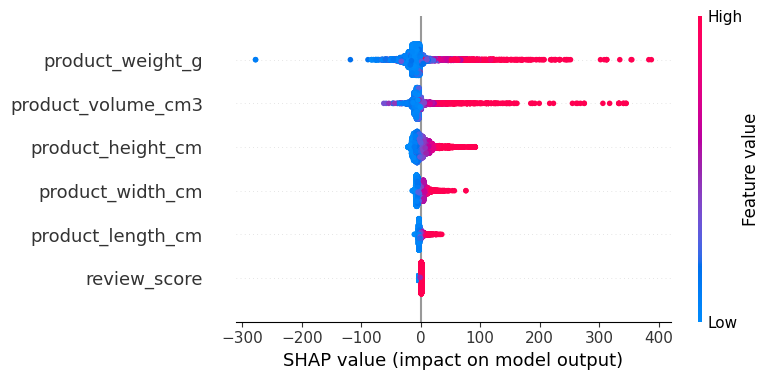

In [74]:
shap.summary_plot(shap_values, X_test)

In [75]:
# dot_data = StringIO()
# export_graphviz(clf, 
#                 out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True,feature_names = feature_cols,class_names=True)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
# graph.write_png('price.png')
# Image(graph.create_png())

# dtree=DecisionTreeClassifier()
# dtree=dtree.fit(X,y)

# tree.plot_tree(dtree, feature_names=feature_cols)

# feature_cols_new=['product_weight_g', 'product_length_cm', 'product_height_cm']
# X_new=new_df[feature_cols_new]
# y_new=new_df.price

# X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.3, random_state=1) # 70% training and 30% test

# # Create Decision Tree classifer object
# clfn = DecisionTreeClassifier()

# # Train Decision Tree Classifer
# clfn = clfn.fit(X_train_new,y_train_new)

# #Predict the response for test dataset
# y_pred_new = clfn.predict(X_test_new)

# # Model Accuracy, how often is the classifier correct?
# print("Accuracy:",metrics.accuracy_score(y_test_new, y_pred_new))

# dot_data= StringIO()
# export_graphviz(clfn, out_file=dot_data, 
#                 filled=True, rounded=True,
#                 special_characters=True,feature_names = feature_cols_new ,class_names=True)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# graph.write_png('price_new.png')
# Image(graph.create_png())

# dtree_new=DecisionTreeClassifier()
# dtree_new=dtree_new.fit(X_train_new,y_train_new)

# tree.plot_tree(dtree_new, feature_names=feature_cols_new)

# # Create Decision Tree classifer object
# clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# # Train Decision Tree Classifer
# clf = clf.fit(X_train,y_train)

# #Predict the response for test dataset
# y_pred = clf.predict(X_test)

# # Model Accuracy, how often is the classifier correct?
# print("Accuracy:",metrics.accuracy_score(y_test, y_pred))